In [ ]:
!pip install mne
!pip install sklearn
!pip install matplotlib
!pip install torch
!pip install torchvision
!pip install tensorboardX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 39.3 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 1.9 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from collections import OrderedDict
from pylab import rcParams
import torch
import torch.nn as nn
import torchvision.transforms
import matplotlib.pyplot as plt
import numpy as np
import mne
from sklearn.preprocessing import RobustScaler
torch.manual_seed(100)

In [ ]:
# Initialize parameters
eeg_sample_count = 240 # How many samples are we training
learning_rate = 1e-3 # How hard the network will correct its mistakes while learning
eeg_sample_length = 226 # Number of eeg data points per sample
number_of_classes = 1 # We want to answer the "is this a P300?" question
hidden1 = 500 # Number of neurons in our first hidden layer
hidden2 = 1000 # Number of neurons in our second hidden layer
hidden3 = 100 # Number of neurons in our third hidden layer
output = 10 # Number of neurons in our output layer


In [ ]:
## Create sample data using the parameters
sample_positives = [None, None] # Element [0] is the sample, Element [1] is the class
sample_positives[0] = torch.rand(int(eeg_sample_count / 2), eeg_sample_length) * 0.50 + 0.25
sample_positives[1] = torch.ones([int(eeg_sample_count / 2), 1], dtype=torch.float32)

sample_negatives = [None, None] # Element [0] is the sample, Element [1] is the class
sample_negatives_low = torch.rand(int(eeg_sample_count / 4), eeg_sample_length) * 0.25
sample_negatives_high = torch.rand(int(eeg_sample_count / 4), eeg_sample_length) * 0.25 + 0.75
sample_negatives[0] = torch.cat([sample_negatives_low, sample_negatives_high], dim = 0)
sample_negatives[1] = torch.zeros([int(eeg_sample_count / 2), 1], dtype=torch.float32)

samples = [None, None] # Combine the two
samples[0] = torch.cat([sample_positives[0], sample_negatives[0]], dim = 0)
samples[1] = torch.cat([sample_positives[1], sample_negatives[1]], dim = 0)

## Create test data that isn't trained on
test_positives = torch.rand(10, eeg_sample_length) * 0.50 + 0.25 # Test 10 good samples
test_negatives_low = torch.rand(5, eeg_sample_length) * 0.25 # Test 5 bad low samples
test_negatives_high = torch.rand(5, eeg_sample_length) * 0.25 + 0.75 # Test 5 bad high samples
test_negatives = torch.cat([test_negatives_low, test_negatives_high], dim = 0)

print("We have created a sample dataset with " + str(samples[0].shape[0]) + " samples")
print("Half of those are positive samples with a score of 100%")
print("Half of those are negative samples with a score of 0%")
print("We have also created two sets of 10 test samples to check the validity of the network")

We have created a sample dataset with 240 samples
Half of those are positive samples with a score of 100%
Half of those are negative samples with a score of 0%
We have also created two sets of 10 test samples to check the validity of the network


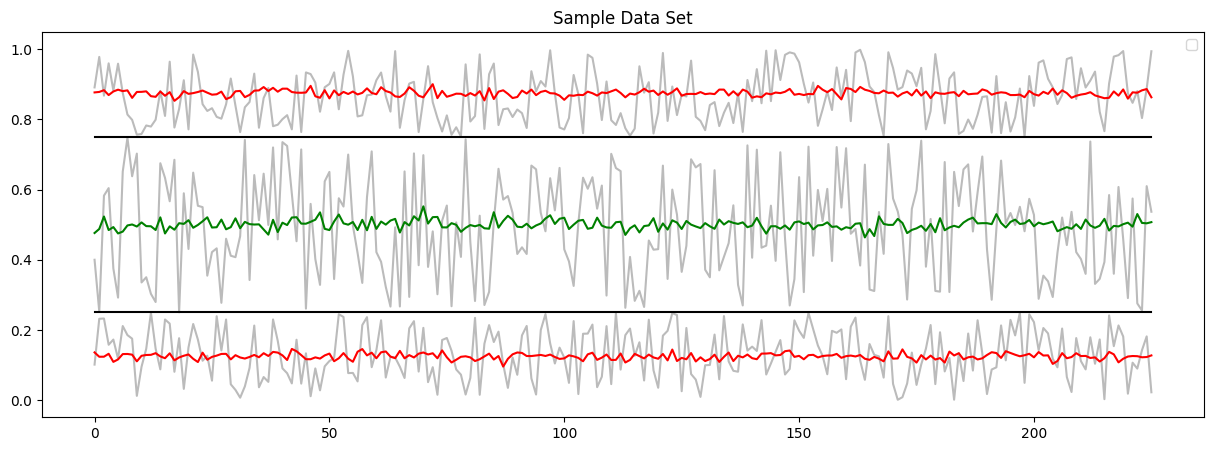

In [ ]:
rcParams['figure.figsize'] = 15, 5

plt.title("Sample Data Set")
plt.legend()
plt.plot(list(range(0, eeg_sample_length)), sample_positives[0][0], color = "#bbbbbb", label = "One Sample")
plt.plot(list(range(0, eeg_sample_length)), sample_positives[0].mean(dim = 0), color = "g", label = "Mean Positive")
plt.plot(list(range(0, eeg_sample_length)), sample_negatives_high[0], color = "#bbbbbb")
plt.plot(list(range(0, eeg_sample_length)), sample_negatives_high.mean(dim = 0), color = "r", label = "Mean Negative")
plt.plot(list(range(0, eeg_sample_length)), sample_negatives_low[0], color = "#bbbbbb")
plt.plot(list(range(0, eeg_sample_length)), sample_negatives_low.mean(dim = 0), color = "r")
plt.plot(list(range(0, eeg_sample_length)), [0.75] * eeg_sample_length, color = "k")
plt.plot(list(range(0, eeg_sample_length)), [0.25] * eeg_sample_length, color = "k")
plt.show()

In [ ]:
## Define the network
tutorial_model = nn.Sequential()

# Input Layer (Size 226 -> 500)
tutorial_model.add_module('Input Linear', nn.Linear(eeg_sample_length, hidden1))
tutorial_model.add_module('Input Activation', nn.CELU())

# Hidden Layer (Size 500 -> 1000)
tutorial_model.add_module('Hidden Linear', nn.Linear(hidden1, hidden2))
tutorial_model.add_module('Hidden Activation', nn.ReLU())

# Hidden Layer (Size 1000 -> 100)
tutorial_model.add_module('Hidden Linear2', nn.Linear(hidden2, hidden3))
tutorial_model.add_module('Hidden Activation2', nn.ReLU())

# Hidden Layer (Size 100 -> 10)
tutorial_model.add_module('Hidden Linear3', nn.Linear(hidden3, 10))
tutorial_model.add_module('Hidden Activation3', nn.ReLU())

# Output Layer (Size 10 -> 1)
tutorial_model.add_module('Output Linear', nn.Linear(10, number_of_classes))
tutorial_model.add_module('Output Activation', nn.Sigmoid())


In [ ]:
# Define a loss function
loss_function = torch.nn.MSELoss()

# Define a training procedure
def train_network(train_data, actual_class, iterations):
    # Keep track of loss at every training iteration
    loss_data = []

    # Begin training for a certain amount of iterations
    for i in range(iterations):
        # Begin with a classification
        classification = tutorial_model(train_data)

        # Find out how wrong the network was
        loss = loss_function(classification, actual_class)
        loss_data.append(loss.item())  # Append loss as a scalar (not a tensor)

        # Zero out the optimizer gradients every iteration
        optimizer.zero_grad()

        # Teach the network how to do better next time
        loss.backward()  # Backpropagate the error
        optimizer.step()  # Update the weights

    # Plot a nice loss graph at the end of training
    plt.figure(figsize=(10, 5))
    plt.title("Loss vs Iterations")
    plt.plot(range(len(loss_data)), loss_data)  # Plot loss without conversion issues
    plt.show()

    # Save the network's default state so we can retrain from the default weights
    torch.save(tutorial_model, "/home/tutorial_model_default_state")

Positive Test 1 Value scored: 54.77%
Positive Test 2 Value scored: 54.73%
Positive Test 3 Value scored: 54.74%
Positive Test 4 Value scored: 54.78%
Positive Test 5 Value scored: 54.72%
Positive Test 6 Value scored: 54.69%
Positive Test 7 Value scored: 54.73%
Positive Test 8 Value scored: 54.66%
Positive Test 9 Value scored: 54.78%
Positive Test 10 Value scored: 54.69%

Negative Test 1 Value scored: 54.59%
Negative Test 2 Value scored: 54.58%
Negative Test 3 Value scored: 54.53%
Negative Test 4 Value scored: 54.58%
Negative Test 5 Value scored: 54.56%
Negative Test 6 Value scored: 54.87%
Negative Test 7 Value scored: 54.87%
Negative Test 8 Value scored: 54.89%
Negative Test 9 Value scored: 54.88%
Negative Test 10 Value scored: 54.87%

Below is a scatter plot of some of the samples
Notice the distinct areas of red and green dots. If the input of this 
network was a simple x and y coordinate, the square band in the center would 
represent the "solution space" of our network. However, an a

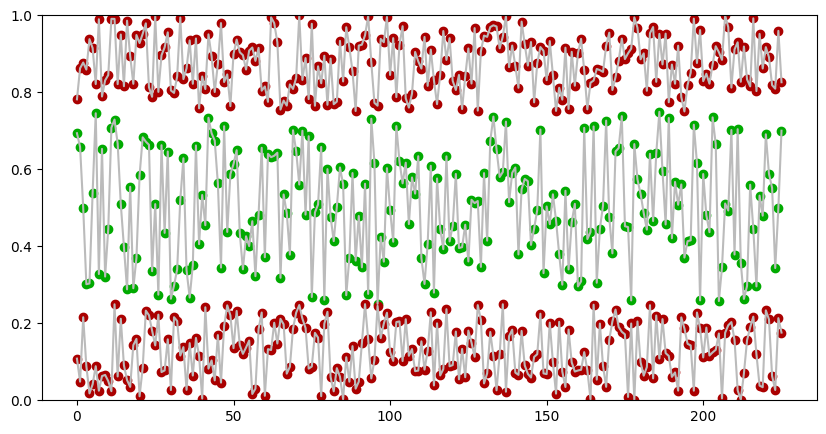

In [ ]:
# Classify our positive test dataset
predicted_positives = tutorial_model(test_positives).data.tolist()

# Print the results
for index, value in enumerate(predicted_positives):
  print("Positive Test {1} Value scored: {0:.2f}%".format(value[0] * 100, index + 1))

print()

#Classify the negative test dataset
predicted_negatives = tutorial_model(test_negatives).data.tolist()

# Print the results
for index, value in enumerate(predicted_negatives):
  print("Negative Test {1} Value scored: {0:.2f}%".format(value[0] * 100, index + 1))

print()

print("Below is a scatter plot of some of the samples")
print("Notice the distinct areas of red and green dots. If the input of this \n" +
"network was a simple x and y coordinate, the square band in the center would \n" +
"represent the \"solution space\" of our network. However, an actual EEG signal \n" +
"sample is an array of several points and can cross the boundary at any time.")
print("Plotted is one positive sample in green and two negative samples in red")

rcParams['figure.figsize'] = 10, 5
plt.scatter(list(range(0, eeg_sample_length)), test_positives[3], color = "#00aa00")
plt.plot(list(range(0, eeg_sample_length)), test_positives[3], color = "#bbbbbb")
plt.scatter(list(range(0, eeg_sample_length)), test_negatives[0], color = "#aa0000")
plt.plot(list(range(0, eeg_sample_length)), test_negatives[0], color = "#bbbbbb")
plt.scatter(list(range(0, eeg_sample_length)), test_negatives[9], color = "#aa0000")
plt.plot(list(range(0, eeg_sample_length)), test_negatives[9], color = "#bbbbbb")
plt.ylim([0 , 1])
plt.show()

In [ ]:
data_path = mne.datasets.sample.data_path()
data_path


Using default location ~/mne_data for sample...
Creating /root/mne_data


100%|██████████████████████████████████████| 1.65G/1.65G [00:00<00:00, 423GB/s]
Untarring contents of '/root/mne_data/MNE-sample-data-processed.tar.gz' to '/root/mne_data'


Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Download complete in 01m55s (1576.2 MB)


PosixPath('/root/mne_data/MNE-sample-data')

In [ ]:
raw_fname = str(data_path) + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
event_fname = str(data_path) + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'

# Obtain a reference to the database and preload into RAM
raw_data = mne.io.read_raw_fif(raw_fname, preload=True)

# EEGs work by detecting the voltage between two points. The second reference
# point is set to be the average of all voltages using the following function.
# It is also possible to set the reference voltage to a different number.
raw_data.set_eeg_reference()

Opening raw data file /root/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.
Created an SSP operator (subspace dimension = 3)


<Raw | sample_audvis_filt-0-40_raw.fif, 376 x 41700 (277.7 s), ~122.9 MB, data loaded>

In [ ]:
# Define what data we want from the dataset
raw_data = raw_data.pick(picks=["eeg","eog"])
picks_eeg_only = mne.pick_types(raw_data.info,
                                eeg=True,
                                eog=True,
                                meg=False,
                                exclude='bads')

In [ ]:
events = mne.read_events(event_fname)
event_id = 5
tmin = -0.5
tmax = 1
epochs = mne.Epochs(raw_data, events, event_id, tmin, tmax, proj=True,
                    picks=picks_eeg_only, baseline=(None, 0), preload=True,
                    reject=dict(eeg=100e-6, eog=150e-6), verbose = False)
print(epochs)


<Epochs | 12 events (all good), -0.499 – 0.999 s (baseline -0.499 – 0 s), ~4.2 MB, data loaded,
 '5': 12>


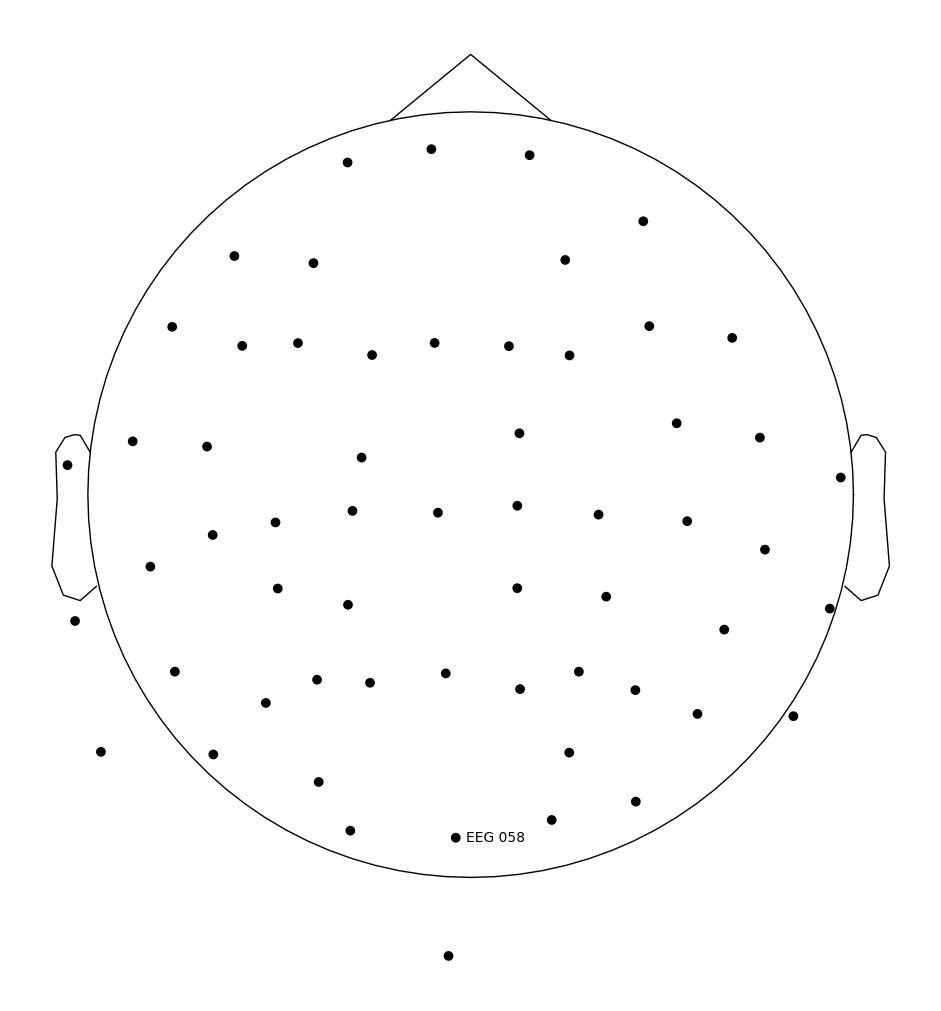

In [ ]:
# This is the channel used to monitor the P300 response
channel = "EEG 058"

# Display a graph of the sensor position we're using
sensor_position_figure = epochs.plot_sensors(show_names=[channel])

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated


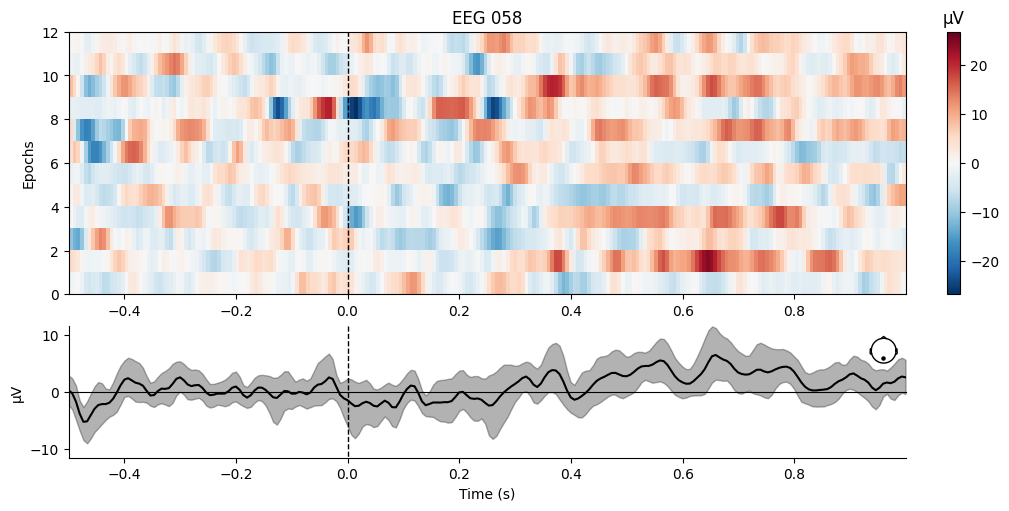

[<Figure size 1000x500 with 4 Axes>]

In [ ]:
epochs.plot_image(picks=channel)

In [ ]:
event_id=[1,2,3,4]
epochsNoP300 = mne.Epochs(raw_data, events, event_id, tmin, tmax, proj=True,
                    picks=picks_eeg_only, baseline=(None, 0), preload=True,
                    reject=dict(eeg=100e-6, eog=150e-6), verbose = False)
print(epochsNoP300)

<Epochs | 208 events (all good), -0.499 – 0.999 s (baseline -0.499 – 0 s), ~24.5 MB, data loaded,
 '1': 47
 '2': 56
 '3': 57
 '4': 48>


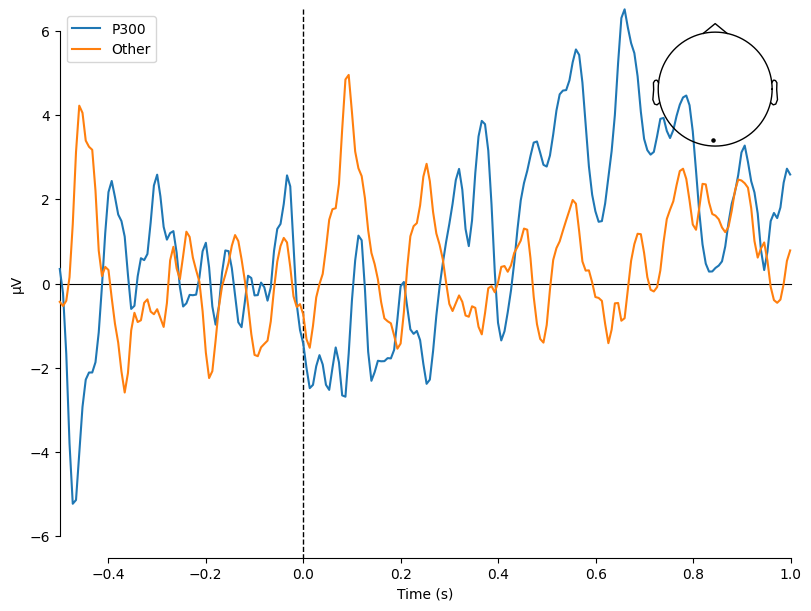

[<Figure size 800x600 with 2 Axes>]

In [ ]:
mne.viz.plot_compare_evokeds({'P300': epochs.average(picks=channel), 'Other': epochsNoP300[0:12].average(picks=channel)})

We’ve got a few more steps to take to fully transform our dataset data into something easily digestible by the neural network. We need to:

Scale the data while being mindful of possible outliers. If we just scale the data using the minimum and the maximum values of our dataset, we run the risk that our data gets defined by outliers and the regular values get squeezed in the center. To avoid this, we can use some statistical values (such as anything a few standard deviations from the mean) to scale our data.
Create a label variable, where the P300 samples are labeled as 1 and the Non-P300 samples are labeled as 0.
Combine the data into a single data structure.
Perform various data type conversions.


In [ ]:
#The code block below does all of this.

eeg_data_scaler = RobustScaler()

# We have 12 p300 samples
p300s = np.squeeze(epochs.get_data(picks=channel))

# We have 208 non-p300 samples
others = np.squeeze(epochsNoP300.get_data(picks=channel))

# Scale the p300 data using the RobustScaler
p300s = p300s.transpose()
p300s = eeg_data_scaler.fit_transform(p300s)
p300s = p300s.transpose()

# Scale the non-p300 data using the RobustScaler
others = others.transpose()
others = eeg_data_scaler.fit_transform(others)
others = others.transpose()

## Prepare the train and test tensors
# Specify Positive P300 train and test samples
p300s_train = p300s[0:9]
p300s_test = p300s[9:12]
p300s_test = torch.tensor(p300s_test).float()

# Specify Negative P300 train and test samples
others_train = others[30:39]
others_test = others[39:42]
others_test = torch.tensor(others_test).float()

# Combine everything into their final structures
training_data = torch.tensor(np.concatenate((p300s_train, others_train), axis = 0)).float()
positive_testing_data = torch.tensor(p300s_test).float()
negative_testing_data = torch.tensor(others_test).float()

# Print the size of each of our data structures
print("training data count: " + str(training_data.shape[0]))
print("positive testing data count: " + str(positive_testing_data.shape[0]))
print("negative testing data count: " + str(negative_testing_data.shape[0]))

# Generate training labels
labels = torch.tensor(np.zeros((training_data.shape[0],1))).float()
labels[0:10] = 1.0
print("training labels count: " + str(labels.shape[0]))


training data count: 18
positive testing data count: 3
negative testing data count: 3
training labels count: 18


Below is the loss graph for dataset training session


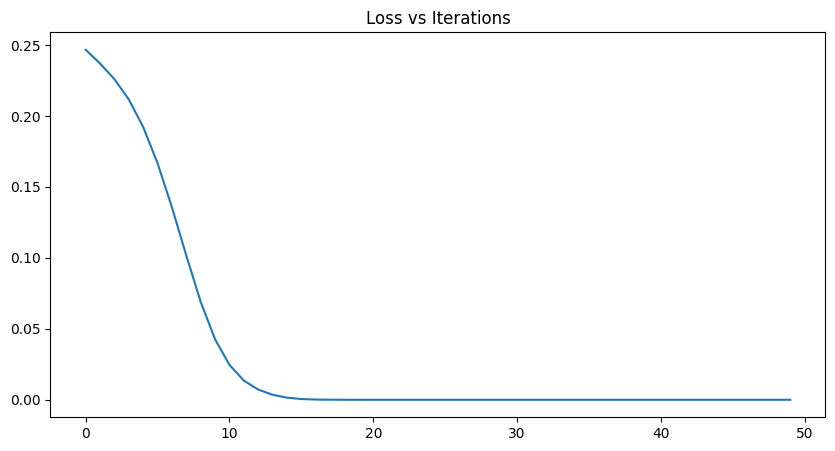

In [ ]:
# Make sure we're starting from untrained every time
tutorial_model = torch.load("/home/tutorial_model_default_state")

## Define a learning function, needs to be reinitialized every load
optimizer = torch.optim.Adam(tutorial_model.parameters(), lr = learning_rate)

## Use our training procedure with the sample data
print("Below is the loss graph for dataset training session")
train_network(training_data, labels, iterations = 50)

In [ ]:
# Classify our positive test dataset and print the results
classification_1 = tutorial_model(positive_testing_data)
for index, value in enumerate(classification_1.data.tolist()):
  print("P300 Positive Classification {1}: {0:.2f}%".format(value[0] * 100, index + 1))

print()

# Classify our negative test dataset and print the results
classification_2 = tutorial_model(negative_testing_data)
for index, value in enumerate(classification_2.data.tolist()):
  print("P300 Negative Classification {1}: {0:.2f}%".format(value[0] * 100, index + 1))

P300 Positive Classification 1: 100.00%
P300 Positive Classification 2: 99.95%
P300 Positive Classification 3: 100.00%

P300 Negative Classification 1: 99.78%
P300 Negative Classification 2: 0.02%
P300 Negative Classification 3: 0.00%


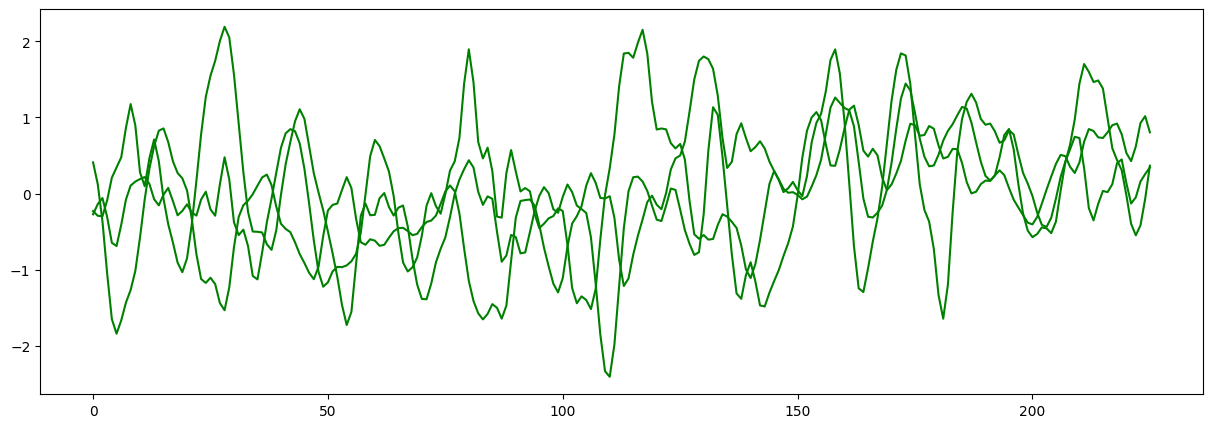

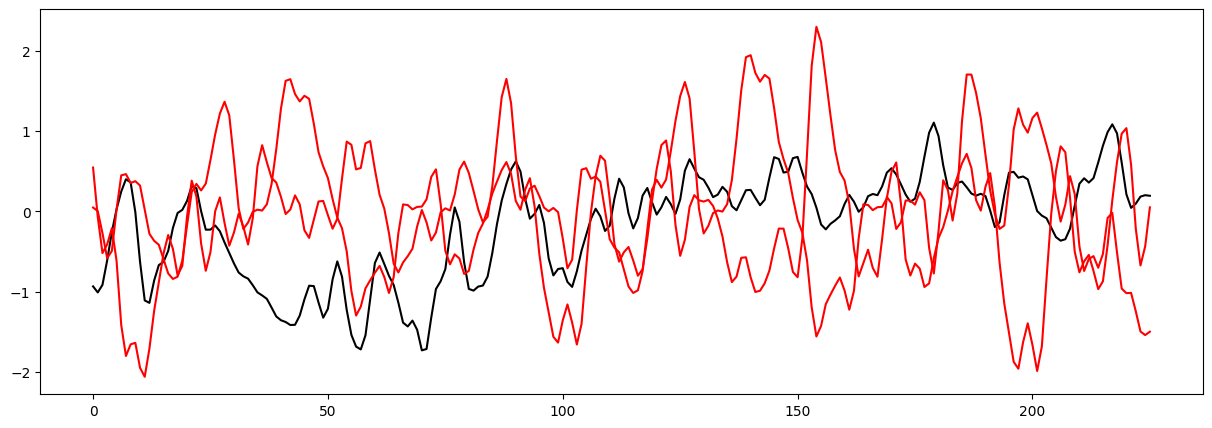

In [ ]:
rcParams['figure.figsize'] = 15, 5

plt.plot(list(range(0, eeg_sample_length)), positive_testing_data[0], color = "g")
plt.plot(list(range(0, eeg_sample_length)), positive_testing_data[1], color = "g")
plt.plot(list(range(0, eeg_sample_length)), positive_testing_data[2], color = "g")
plt.show()
plt.plot(list(range(0, eeg_sample_length)), negative_testing_data[0], color = "black")
plt.plot(list(range(0, eeg_sample_length)), negative_testing_data[1], color = "r")
plt.plot(list(range(0, eeg_sample_length)), negative_testing_data[2], color = "r")
plt.show()

Our network was able to gain some knowledge from the test data provided through the MNE database. Using that knowledge, it was able to predict P300s from brain waves that it had never seen before, and solves our initial problem of detecting surprise in subjects.

Unfortunately, the small amount of data (9 brain waves for each class) to was available to us means that the solution it landed on was not very robust to new unique features. Here is a summary of all the other “Non-P300” data that we didn’t use from the database and the network’s classification of it:

Average Negative Score: 37.79%
Proportion of Non-P300s Classified Correctly: 61.73%
The network performs better than random chance (50%), however there seems to be some room for improvement. This is the result of the network not being complex enough to learn the intricacies of the data, and also not receiving enough examples of what P300s look like. Averaged out, the graphs are easily discernible by the average reader, but individual trials are significantly more ambiguous.

There are a few techniques available to us if we want to improve the network’s performance. These exercises are left to the reader:

Increase the complexity of the network. This can include more layers, more neurons, more inputs, or altered hyperparameters (For example: modifying learning rate, testing different activation functions, or adding convolutional layers)
Warning: A consequence in increased complexity in a network is that the network might require significantly more data to train. Also, increasing the learning rate may harbor undesired results.
Increase the amount of data we train on. There are plenty of free data sets available online which provide a number of different types of data. MNE has a decent number available. Here are a few to try:
https://ieee-dataport.org/documents/event-related-potentials-p300-eeg-bci-dataset
http://predict.cs.unm.edu/
https://mne.tools/stable/python_reference.html#datasets
Experiment with different network structures. This technique is by far the most difficult, but since neural networks are just a graph, they can be drawn in any way you’d like! Try out a network that separates the data into two sides. Or a network that has recurrent connections (a loop where two layers feed into each other’s inputs) if you are brave enough. (Warning: it might never return from a training iteration).
